In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import h5py


D:\Anaconda3\envs\pytorch\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader

In [3]:
import sys
# Import FBP
sys.path.append('../FBPConvNet/')
from FBPConvNet import Generator, Discriminator

sys.path.append('../')
from net_utils import get_datetime,train_net

# Generate Example Data

In [4]:
def preprocess(data):
    return torch.Tensor(data).unsqueeze(1)
def target_ones(N,GPU=False):
    if GPU:
        return torch.ones(N,1).cuda()
    else:
        return torch.ones(N,1)

def target_noisy_ones(N,GPU=False):
    # maps between .7 and 1.2
    labels = torch.rand((N,1))*.5+.7
    if GPU:
        return labels.cuda()
    return labels
    
def target_zeros(N,GPU=False):
    if GPU:
        return torch.zeros(N,1).cuda()
    else:
        return torch.zeros(N,1)   

def target_noisy_zeros(N,GPU=False):
    # maps between .7 and 1.2
    labels = torch.rand((N,1))*.3
    if GPU:
        return labels.cuda()
    return labels

In [16]:
# set path to data
pathtodata = '../EllipseGeneration/RandomLineEllipses15.hdf5'
dataset_size = 200
batch_size = 2

In [6]:
# f = h5py.File(pathtodata,'r')
# print([ key for key in f['ellip']])
# fakeinput = preprocess(f['ellip/training_data'][0:dataset_size])
# fakelabels = preprocess(f['ellip/training_labels'][0:dataset_size])
# reallabels = preprocess(f['ellip/training_labels'][dataset_size:2*dataset_size])

# testinput = preprocess(f['ellip/test_data'])
# testlabels = preprocess(f['ellip/test_labels'])
# f.close()

In [6]:
# f = h5py.File(pathtodata,'r')
# print([ key for key in f['ellip']])

# fakeinput1 = f['ellip/training_data'][0:dataset_size]
# fakeinput2 = fakeinput1.copy()[:,:,::-1]
# fakeinput = preprocess(np.concatenate((fakeinput1,fakeinput2)))

# fakelabels1 = f['ellip/training_labels'][0:dataset_size]
# fakelabels2 = fakelabels1.copy()[:,:,::-1]
# fakelabels = preprocess(np.concatenate((fakelabels1,fakelabels2)))

# reallabels1 = f['ellip/training_labels'][dataset_size:2*dataset_size]
# reallabels2 = reallabels1.copy()[:,:,::-1]
# reallabels = preprocess(np.concatenate((reallabels1,reallabels2)))

# del fakeinput1, fakeinput2, fakelabels1, fakelabels2, reallabels1, reallabels2

# testinput = preprocess(f['ellip/test_data'])
# testlabels = preprocess(f['ellip/test_labels'])
# f.close()

['test_data', 'test_labels', 'training_data', 'training_labels']


In [10]:
f = h5py.File(pathtodata,'r')
print([ key for key in f['ellip']])

fakeinput1 = f['ellip/training_data'][0:]
fakeinput2 = fakeinput1.copy()[:,:,::-1]
fakeinput = preprocess(np.concatenate((fakeinput1,fakeinput2)))

fakelabels1 = f['ellip/training_labels'][0:]
fakelabels2 = fakelabels1.copy()[:,:,::-1]
fakelabels = preprocess(np.concatenate((fakelabels1,fakelabels2)))


del fakeinput1, fakeinput2, fakelabels1, fakelabels2, 

testinput = preprocess(f['ellip/test_data'])
testlabels = preprocess(f['ellip/test_labels'])
f.close()

['test_data', 'test_labels', 'training_data', 'training_labels']


In [17]:
faketrainset = TensorDataset(fakeinput,fakelabels)
testset = TensorDataset(testinput,testlabels)

faketrainloader = DataLoader(faketrainset,batch_size=batch_size,shuffle=True)
#realtrainloader = DataLoader(reallabels, batch_size=batch_size,shuffle=True)
testloader = DataLoader(testset,batch_size=1,shuffle=False)

In [13]:
len(faketrainloader)
# realiter = iter(realtrainloader)
# for i in range(len(realtrainloader)):
#     data = realiter.next()
#     print(data.size())

800

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # Input 1 x 256 x 256 -> 64 x 256 x 256
        self.conv1 = nn.Conv2d(1,64,3,padding=1,stride=1)    
        self.batch1 = nn.BatchNorm2d(64)
        
        # -> 128 x 128 x 128
        self.conv2 = nn.Conv2d(64,128,7,padding=3,stride=2)
        self.batch2 = nn.BatchNorm2d(128)

        # -> 256 x 32 x 32 -> 256 x 22 x 22
        self.conv3 = nn.Conv2d(128,256,5,padding=2,stride=2)
        self.batch3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256,256,7,padding=3,stride=3)
        self.batch4 = nn.BatchNorm2d(256)
        
        # -> 512 x 8 x 8
        self.conv5 = nn.Conv2d(256,512,5,padding=2,stride=3)
        self.batch5 = nn.BatchNorm2d(512)
        
        # -> 1024 x 1 x 1
        self.conv6 = nn.Conv2d(512,1024,5,padding=2,stride=3)
        self.batch6 = nn.BatchNorm2d(1024)
        self.conv7 = nn.Conv2d(1024,1024,3,padding=1,stride=3)
        #self.batch7 = nn.BatchNorm2d(1024)
        
        # Decision layers
        self.conv8 = nn.Conv2d(1024,1024,1)
        self.conv9 = nn.Conv2d(1024,1024,1)
        self.conv10 = nn.Conv2d(1024,1,1)
        
        # Non-Linear Activations
        self.leaky = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
        self.conv2_drop = nn.Dropout2d(p=.2)
        
        
        
    def forward(self,x):
        # Generate Features
        x = self.leaky(self.batch1(self.conv1(x)))
        x = self.leaky(self.batch2(self.conv2(x)))
        x = self.leaky(self.batch3(self.conv3(x)))
        x = self.leaky(self.batch4(self.conv4(x)))
        x = self.leaky(self.batch5(self.conv5(x)))
        x = self.leaky(self.batch6(self.conv6(x)))
        x = self.leaky(self.conv7(x))
        
        # Decision Layers
        x = self.leaky(self.conv2_drop(self.conv8(x)))
        x = self.leaky(self.conv2_drop(self.conv9(x)))
        x = self.sigmoid(self.conv10(x))
        return x[:,:,0,0]
#         x1_1 = self.batch1(self.elu(self.conv1_1(x)))
#         x1_2 = self.batch1(self.elu(self.conv1_2(x1_1)))
#         x1_3 = self.batch1(self.elu(self.conv1_2(x1_2)))
#         x1 = self.maxpool(x1_3)
        
#         x2_1 = self.batch2(self.elu(self.conv2_1(x1)))
#         x2_2 = self.batch2(self.elu(self.conv2_2(x2_1)))
#         x2 = self.maxpool(x2_2)
        
#         x3_1 = self.batch3(self.elu(self.conv3_1(x2)))
#         x3_2 = self.batch3(self.elu(self.conv3_2(x3_1)))
#         x3 = self.maxpool(x3_2)
        
#         x4_1 = self.batch4(self.elu(self.conv4_1(x3)))
#         x4_2 = self.batch4(self.elu(self.conv4_2(x4_1)))

#         x5_1 = self.deconv5(x4_2)
#         x5_2 = torch.cat((x3_2,x5_1),1)
#         x5_3 = self.batch3(self.elu(self.conv5_1(x5_2)))
#         x5 = self.batch3(self.elu(self.conv5_2(x5_3)))
        
#         x6_1 = self.deconv6(x5)
#         x6_2 = torch.cat((x2_2,x6_1),1)
#         x6_3 = self.batch2(self.elu(self.conv6_1(x6_2)))
#         x6 = self.batch2(self.elu(self.conv6_2(x6_3)))
        
#         x7_1 = self.deconv7(x6)
#         x7_2 = torch.cat((x1_3,x7_1),1)
#         x7_3 = self.batch1(self.elu(self.conv7_1(x7_2)))
#         x7 = self.batch1(self.elu(self.conv7_2(x7_3)))
        
#         x8 = self.conv8(x7)
#         y = x8 + x
        
#         return y

# Training Pseudocode

In [10]:
import time
import os

In [11]:
def train_GANs(G, D, faketrainloader, realtrainloader, num_epochs=500, GPU=False,
              weightpath='./weights/',save_epoch=50,saveweights=True):
    # Create output directory
    weightpath = os.path.join(weightpath,get_datetime())
    os.makedirs(weightpath)
    logpath = os.path.join(weightpath,'log.txt')
    
    with open(logpath, "wt") as text_file:
        print('Epoch\tD Loss\tG Loss\tEpoch Time\tTotal Time',file=text_file)

    num_data = len(realtrainloader)*realtrainloader.batch_size 
    d_losses = np.zeros(num_epochs)
    g_losses = np.zeros(num_epochs)

    # Accumulate log text
    logtxt = ''
    
    # Determine minibatch size
    minibatch = max(1,int(len(realtrainloader))/10)
    
    # Define Loss Function/Optimizer
    bceloss = nn.BCELoss()
    mseloss = nn.MSELoss()

    d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
    g_optimizer = optim.Adam(G.parameters(), lr=0.0002)

    
    G.train()
    trainstart = time.time()
    for epoch in range(num_epochs):
        # Collect loss information
        d_epoch_loss = 0.0
        g_epoch_loss = 0.0
        d_running_loss = 0.0
        g_running_loss = 0.0
        
        epochstart = time.time()

        fakeiter = iter(faketrainloader)
        realiter = iter(realtrainloader)
        Giter = iter(faketrainloader)
        for batch_index in range(len(realtrainloader)):
            ## prepare data
            truelabels = realiter.next()
            fakeinput, _ = fakeiter.next()
            batch_size = truelabels.size(0)


            if GPU:
                truelabels = truelabels.cuda()
                fakeinput = fakeinput.cuda()
    #             fakelabel = fakelabel.cuda()
            d_real_data = Variable(truelabels)
            d_gen_input = Variable(fakeinput)
            d_fake_data = G(d_gen_input).detach() # detach to avoid training G on these labels
            
            ## Train D
            d_optimizer.zero_grad()

            # Train D on real
            d_real_decision = D(d_real_data)
            d_real_error = bceloss(d_real_decision, Variable(target_noisy_ones(batch_size,GPU)))
            d_real_error.backward()

            # Train D on fake

            d_fake_decision = D(d_fake_data)
            d_fake_error = bceloss(d_fake_decision, Variable(target_noisy_zeros(batch_size,GPU))) 
            d_fake_error.backward()
            d_optimizer.step()
            d_loss = d_real_error+d_fake_error
            
            d_running_loss += d_loss.data[0]
            d_losses[epoch] += d_loss.data[0]
            
        
            ## Train G
            g_fake_input, g_fake_label = Giter.next()
            batch_size = g_fake_input.size(0)

            if GPU:
                g_fake_input = g_fake_input.cuda()
                g_fake_label = g_fake_label.cuda()

            gen_input = Variable(g_fake_input)
            g_fake_data = G(gen_input)
  
            g_optimizer.zero_grad()

            dg_fake_decision = D(g_fake_data)
            g_loss = (10**-2)*bceloss(dg_fake_decision, Variable(target_noisy_ones(batch_size,GPU)))
            g_loss +=  mseloss(g_fake_data,Variable(g_fake_label))

            g_loss.backward()
            g_optimizer.step()
            
            g_running_loss += g_loss.data[0]
            g_losses[epoch] += g_loss.data[0]
            
            # print statistics
            if (batch_index+1) % minibatch == 0:
                print('\t[%d, %5d] D loss: %.3f, G loss: %.3f, %.3f seconds elapsed' %
                      (epoch + 1, batch_index + 1, d_running_loss / minibatch, 
                       g_running_loss/minibatch, time.time() - epochstart))
                d_running_loss = 0.0
                g_running_loss = 0.0
        # Record epoch statistics
        epochend = time.time()        
        print('Epoch %d Training Time: %.3f seconds\nTotal Elapsed Time: %.3f seconds' %
               (epoch+1, epochend-epochstart,epochend-trainstart))
        
        # log losses
        d_losses[epoch] /= num_data
        g_losses[epoch] /= num_data
        logtxt += '%i\t%f\t%f\t%f\t%f\n' % (epoch+1,d_losses[epoch], g_losses[epoch],
                                           epochend-epochstart,epochend-trainstart)

        
        # Save weights
        if (epoch % save_epoch == 0 or epoch == num_epochs-1):
            if saveweights:
                d_outpath = os.path.join(weightpath,'D_epoch_'+str(epoch+1)+'.weights')
                g_outpath = os.path.join(weightpath,'G_epoch_'+str(epoch+1)+'.weights')
                D = D.cpu()
                G = G.cpu()
                torch.save(D.state_dict(),d_outpath)
                torch.save(G.state_dict(),g_outpath)

                if GPU:
                    D = D.cuda()
                    G = G.cuda()
            
            # write loss to logfile
            with open(logpath, "at") as text_file:
                print(logtxt[:-2],file=text_file)
                logtxt = ''

    print('Finished Training')
    return d_losses,g_losses


In [14]:
#D = Discriminator()
G = Generator()

In [99]:
#weightspath = '../FBPConvNet/weights/2018-05-07_14-50-41/epoch_500.weights'
# weightspath = './weights/2018-06-04_18-34-00/G_epoch_126.weights'

# checkpoint = torch.load(weightspath)
# G.load_state_dict(checkpoint)

In [18]:
torch.cuda.empty_cache()
num_epochs = 500

GPU = True
if GPU:
    # D = D.cuda()
    G = G.cuda()
# d_losses, g_losses = train_GANs(G,D,faketrainloader,realtrainloader,num_epochs=num_epochs,save_epoch=25,GPU=GPU)
train_net(G,faketrainloader,num_epochs=num_epochs,GPU=GPU,save_epoch=25)

	[1,    40] loss: 0.004, 7.328 seconds elapsed
	[1,    80] loss: 0.004, 14.615 seconds elapsed
	[1,   120] loss: 0.003, 21.915 seconds elapsed
	[1,   160] loss: 0.003, 29.239 seconds elapsed
	[1,   200] loss: 0.003, 36.597 seconds elapsed
	[1,   240] loss: 0.002, 43.954 seconds elapsed
	[1,   280] loss: 0.002, 51.280 seconds elapsed
	[1,   320] loss: 0.002, 58.625 seconds elapsed
	[1,   360] loss: 0.002, 65.980 seconds elapsed
	[1,   400] loss: 0.002, 73.347 seconds elapsed
Epoch 1 Training Time: 73.348 seconds
Total Elapsed Time: 73.348 seconds
	[2,    40] loss: 0.002, 7.338 seconds elapsed
	[2,    80] loss: 0.002, 14.751 seconds elapsed
	[2,   120] loss: 0.002, 22.122 seconds elapsed
	[2,   160] loss: 0.002, 29.536 seconds elapsed
	[2,   200] loss: 0.002, 36.880 seconds elapsed
	[2,   240] loss: 0.002, 44.257 seconds elapsed
	[2,   280] loss: 0.002, 51.635 seconds elapsed
	[2,   320] loss: 0.002, 59.014 seconds elapsed
	[2,   360] loss: 0.002, 66.378 seconds elapsed
	[2,   400] loss:

	[15,   400] loss: 0.002, 73.827 seconds elapsed
Epoch 15 Training Time: 73.828 seconds
Total Elapsed Time: 1106.611 seconds
	[16,    40] loss: 0.001, 7.372 seconds elapsed
	[16,    80] loss: 0.002, 14.721 seconds elapsed
	[16,   120] loss: 0.002, 22.098 seconds elapsed
	[16,   160] loss: 0.001, 29.490 seconds elapsed
	[16,   200] loss: 0.002, 36.848 seconds elapsed
	[16,   240] loss: 0.002, 44.216 seconds elapsed
	[16,   280] loss: 0.002, 51.543 seconds elapsed
	[16,   320] loss: 0.002, 58.916 seconds elapsed
	[16,   360] loss: 0.002, 66.290 seconds elapsed
	[16,   400] loss: 0.001, 73.648 seconds elapsed
Epoch 16 Training Time: 73.648 seconds
Total Elapsed Time: 1180.259 seconds
	[17,    40] loss: 0.002, 7.351 seconds elapsed
	[17,    80] loss: 0.002, 14.733 seconds elapsed
	[17,   120] loss: 0.002, 22.107 seconds elapsed
	[17,   160] loss: 0.001, 29.454 seconds elapsed
	[17,   200] loss: 0.001, 36.831 seconds elapsed
	[17,   240] loss: 0.002, 44.173 seconds elapsed
	[17,   280] loss

	[30,   200] loss: 0.001, 36.763 seconds elapsed
	[30,   240] loss: 0.001, 44.133 seconds elapsed
	[30,   280] loss: 0.001, 51.457 seconds elapsed
	[30,   320] loss: 0.001, 58.801 seconds elapsed
	[30,   360] loss: 0.001, 66.147 seconds elapsed
	[30,   400] loss: 0.001, 73.490 seconds elapsed
Epoch 30 Training Time: 73.490 seconds
Total Elapsed Time: 2210.929 seconds
	[31,    40] loss: 0.001, 7.368 seconds elapsed
	[31,    80] loss: 0.001, 14.719 seconds elapsed
	[31,   120] loss: 0.001, 22.059 seconds elapsed
	[31,   160] loss: 0.002, 29.408 seconds elapsed
	[31,   200] loss: 0.001, 36.772 seconds elapsed
	[31,   240] loss: 0.001, 44.099 seconds elapsed
	[31,   280] loss: 0.001, 51.460 seconds elapsed
	[31,   320] loss: 0.001, 58.798 seconds elapsed
	[31,   360] loss: 0.002, 66.142 seconds elapsed
	[31,   400] loss: 0.001, 73.500 seconds elapsed
Epoch 31 Training Time: 73.501 seconds
Total Elapsed Time: 2284.431 seconds
	[32,    40] loss: 0.001, 7.343 seconds elapsed
	[32,    80] loss

	[45,    40] loss: 0.001, 7.352 seconds elapsed
	[45,    80] loss: 0.001, 14.698 seconds elapsed
	[45,   120] loss: 0.001, 22.027 seconds elapsed
	[45,   160] loss: 0.001, 29.384 seconds elapsed
	[45,   200] loss: 0.001, 36.742 seconds elapsed
	[45,   240] loss: 0.001, 44.092 seconds elapsed
	[45,   280] loss: 0.001, 51.447 seconds elapsed
	[45,   320] loss: 0.001, 58.786 seconds elapsed
	[45,   360] loss: 0.001, 66.119 seconds elapsed
	[45,   400] loss: 0.001, 73.418 seconds elapsed
Epoch 45 Training Time: 73.419 seconds
Total Elapsed Time: 3312.305 seconds
	[46,    40] loss: 0.001, 7.319 seconds elapsed
	[46,    80] loss: 0.001, 14.637 seconds elapsed
	[46,   120] loss: 0.001, 21.976 seconds elapsed
	[46,   160] loss: 0.001, 29.300 seconds elapsed
	[46,   200] loss: 0.001, 36.609 seconds elapsed
	[46,   240] loss: 0.001, 43.974 seconds elapsed
	[46,   280] loss: 0.001, 51.302 seconds elapsed
	[46,   320] loss: 0.001, 58.658 seconds elapsed
	[46,   360] loss: 0.001, 65.989 seconds ela

	[59,   280] loss: 0.001, 51.327 seconds elapsed
	[59,   320] loss: 0.001, 58.648 seconds elapsed
	[59,   360] loss: 0.001, 65.998 seconds elapsed
	[59,   400] loss: 0.001, 73.353 seconds elapsed
Epoch 59 Training Time: 73.353 seconds
Total Elapsed Time: 4339.272 seconds
	[60,    40] loss: 0.001, 7.339 seconds elapsed
	[60,    80] loss: 0.001, 14.680 seconds elapsed
	[60,   120] loss: 0.001, 22.027 seconds elapsed
	[60,   160] loss: 0.001, 29.353 seconds elapsed
	[60,   200] loss: 0.001, 36.679 seconds elapsed
	[60,   240] loss: 0.001, 43.990 seconds elapsed
	[60,   280] loss: 0.001, 51.360 seconds elapsed
	[60,   320] loss: 0.001, 58.700 seconds elapsed
	[60,   360] loss: 0.001, 66.038 seconds elapsed
	[60,   400] loss: 0.001, 73.369 seconds elapsed
Epoch 60 Training Time: 73.369 seconds
Total Elapsed Time: 4412.642 seconds
	[61,    40] loss: 0.001, 7.308 seconds elapsed
	[61,    80] loss: 0.001, 14.669 seconds elapsed
	[61,   120] loss: 0.001, 22.014 seconds elapsed
	[61,   160] loss

	[74,    80] loss: 0.001, 14.618 seconds elapsed
	[74,   120] loss: 0.001, 21.938 seconds elapsed
	[74,   160] loss: 0.001, 29.269 seconds elapsed
	[74,   200] loss: 0.001, 36.583 seconds elapsed
	[74,   240] loss: 0.001, 43.913 seconds elapsed
	[74,   280] loss: 0.001, 51.207 seconds elapsed
	[74,   320] loss: 0.001, 58.536 seconds elapsed
	[74,   360] loss: 0.001, 65.881 seconds elapsed
	[74,   400] loss: 0.001, 73.190 seconds elapsed
Epoch 74 Training Time: 73.191 seconds
Total Elapsed Time: 5439.584 seconds
	[75,    40] loss: 0.001, 7.354 seconds elapsed
	[75,    80] loss: 0.001, 14.663 seconds elapsed
	[75,   120] loss: 0.001, 22.004 seconds elapsed
	[75,   160] loss: 0.001, 29.365 seconds elapsed
	[75,   200] loss: 0.001, 36.723 seconds elapsed
	[75,   240] loss: 0.001, 44.070 seconds elapsed
	[75,   280] loss: 0.001, 51.433 seconds elapsed
	[75,   320] loss: 0.001, 58.756 seconds elapsed
	[75,   360] loss: 0.001, 66.088 seconds elapsed
	[75,   400] loss: 0.001, 73.441 seconds el

	[88,   320] loss: 0.001, 58.663 seconds elapsed
	[88,   360] loss: 0.001, 66.031 seconds elapsed
	[88,   400] loss: 0.001, 73.375 seconds elapsed
Epoch 88 Training Time: 73.375 seconds
Total Elapsed Time: 6466.862 seconds
	[89,    40] loss: 0.001, 7.318 seconds elapsed
	[89,    80] loss: 0.001, 14.669 seconds elapsed
	[89,   120] loss: 0.001, 22.025 seconds elapsed
	[89,   160] loss: 0.001, 29.347 seconds elapsed
	[89,   200] loss: 0.001, 36.687 seconds elapsed
	[89,   240] loss: 0.001, 44.031 seconds elapsed
	[89,   280] loss: 0.001, 51.358 seconds elapsed
	[89,   320] loss: 0.001, 58.684 seconds elapsed
	[89,   360] loss: 0.001, 66.025 seconds elapsed
	[89,   400] loss: 0.001, 73.343 seconds elapsed
Epoch 89 Training Time: 73.343 seconds
Total Elapsed Time: 6540.206 seconds
	[90,    40] loss: 0.001, 7.349 seconds elapsed
	[90,    80] loss: 0.001, 14.694 seconds elapsed
	[90,   120] loss: 0.001, 22.027 seconds elapsed
	[90,   160] loss: 0.001, 29.363 seconds elapsed
	[90,   200] loss

	[103,    80] loss: 0.001, 14.726 seconds elapsed
	[103,   120] loss: 0.001, 22.091 seconds elapsed
	[103,   160] loss: 0.001, 29.405 seconds elapsed
	[103,   200] loss: 0.001, 36.750 seconds elapsed
	[103,   240] loss: 0.001, 44.071 seconds elapsed
	[103,   280] loss: 0.001, 51.421 seconds elapsed
	[103,   320] loss: 0.001, 58.788 seconds elapsed
	[103,   360] loss: 0.001, 66.114 seconds elapsed
	[103,   400] loss: 0.001, 73.460 seconds elapsed
Epoch 103 Training Time: 73.461 seconds
Total Elapsed Time: 7568.577 seconds
	[104,    40] loss: 0.001, 7.323 seconds elapsed
	[104,    80] loss: 0.001, 14.672 seconds elapsed
	[104,   120] loss: 0.001, 22.004 seconds elapsed
	[104,   160] loss: 0.001, 29.356 seconds elapsed
	[104,   200] loss: 0.001, 36.691 seconds elapsed
	[104,   240] loss: 0.001, 44.022 seconds elapsed
	[104,   280] loss: 0.001, 51.373 seconds elapsed
	[104,   320] loss: 0.001, 58.714 seconds elapsed
	[104,   360] loss: 0.001, 66.051 seconds elapsed
	[104,   400] loss: 0.00

	[117,   200] loss: 0.001, 36.704 seconds elapsed
	[117,   240] loss: 0.001, 44.067 seconds elapsed
	[117,   280] loss: 0.001, 51.425 seconds elapsed
	[117,   320] loss: 0.001, 58.757 seconds elapsed
	[117,   360] loss: 0.001, 66.112 seconds elapsed
	[117,   400] loss: 0.001, 73.476 seconds elapsed
Epoch 117 Training Time: 73.476 seconds
Total Elapsed Time: 8596.539 seconds
	[118,    40] loss: 0.001, 7.354 seconds elapsed
	[118,    80] loss: 0.001, 14.695 seconds elapsed
	[118,   120] loss: 0.001, 22.026 seconds elapsed
	[118,   160] loss: 0.001, 29.377 seconds elapsed
	[118,   200] loss: 0.001, 36.717 seconds elapsed
	[118,   240] loss: 0.001, 44.057 seconds elapsed
	[118,   280] loss: 0.001, 51.405 seconds elapsed
	[118,   320] loss: 0.001, 58.774 seconds elapsed
	[118,   360] loss: 0.001, 66.128 seconds elapsed
	[118,   400] loss: 0.001, 73.463 seconds elapsed
Epoch 118 Training Time: 73.463 seconds
Total Elapsed Time: 8670.002 seconds
	[119,    40] loss: 0.001, 7.356 seconds elapse

	[131,   320] loss: 0.001, 58.738 seconds elapsed
	[131,   360] loss: 0.001, 66.105 seconds elapsed
	[131,   400] loss: 0.001, 73.455 seconds elapsed
Epoch 131 Training Time: 73.455 seconds
Total Elapsed Time: 9625.155 seconds
	[132,    40] loss: 0.001, 7.369 seconds elapsed
	[132,    80] loss: 0.001, 14.699 seconds elapsed
	[132,   120] loss: 0.001, 22.057 seconds elapsed
	[132,   160] loss: 0.001, 29.385 seconds elapsed
	[132,   200] loss: 0.001, 36.730 seconds elapsed
	[132,   240] loss: 0.001, 44.080 seconds elapsed
	[132,   280] loss: 0.001, 51.419 seconds elapsed
	[132,   320] loss: 0.001, 58.734 seconds elapsed
	[132,   360] loss: 0.001, 66.091 seconds elapsed
	[132,   400] loss: 0.001, 73.451 seconds elapsed
Epoch 132 Training Time: 73.452 seconds
Total Elapsed Time: 9698.606 seconds
	[133,    40] loss: 0.001, 7.356 seconds elapsed
	[133,    80] loss: 0.001, 14.692 seconds elapsed
	[133,   120] loss: 0.001, 22.049 seconds elapsed
	[133,   160] loss: 0.001, 29.389 seconds elapse

	[146,    40] loss: 0.001, 7.358 seconds elapsed
	[146,    80] loss: 0.001, 14.691 seconds elapsed
	[146,   120] loss: 0.001, 22.037 seconds elapsed
	[146,   160] loss: 0.001, 29.412 seconds elapsed
	[146,   200] loss: 0.001, 36.745 seconds elapsed
	[146,   240] loss: 0.001, 44.100 seconds elapsed
	[146,   280] loss: 0.001, 51.436 seconds elapsed
	[146,   320] loss: 0.001, 58.783 seconds elapsed
	[146,   360] loss: 0.001, 66.141 seconds elapsed
	[146,   400] loss: 0.001, 73.471 seconds elapsed
Epoch 146 Training Time: 73.472 seconds
Total Elapsed Time: 10727.382 seconds
	[147,    40] loss: 0.001, 7.343 seconds elapsed
	[147,    80] loss: 0.001, 14.672 seconds elapsed
	[147,   120] loss: 0.001, 22.028 seconds elapsed
	[147,   160] loss: 0.001, 29.378 seconds elapsed
	[147,   200] loss: 0.001, 36.712 seconds elapsed
	[147,   240] loss: 0.001, 44.063 seconds elapsed
	[147,   280] loss: 0.001, 51.395 seconds elapsed
	[147,   320] loss: 0.001, 58.738 seconds elapsed
	[147,   360] loss: 0.00

	[160,   160] loss: 0.001, 29.370 seconds elapsed
	[160,   200] loss: 0.001, 36.707 seconds elapsed
	[160,   240] loss: 0.001, 44.071 seconds elapsed
	[160,   280] loss: 0.001, 51.436 seconds elapsed
	[160,   320] loss: 0.001, 58.799 seconds elapsed
	[160,   360] loss: 0.001, 66.136 seconds elapsed
	[160,   400] loss: 0.001, 73.486 seconds elapsed
Epoch 160 Training Time: 73.486 seconds
Total Elapsed Time: 11756.203 seconds
	[161,    40] loss: 0.001, 7.324 seconds elapsed
	[161,    80] loss: 0.001, 14.676 seconds elapsed
	[161,   120] loss: 0.001, 22.028 seconds elapsed
	[161,   160] loss: 0.001, 29.356 seconds elapsed
	[161,   200] loss: 0.001, 36.704 seconds elapsed
	[161,   240] loss: 0.001, 44.054 seconds elapsed
	[161,   280] loss: 0.001, 51.395 seconds elapsed
	[161,   320] loss: 0.001, 58.750 seconds elapsed
	[161,   360] loss: 0.001, 66.109 seconds elapsed
	[161,   400] loss: 0.001, 73.474 seconds elapsed
Epoch 161 Training Time: 73.475 seconds
Total Elapsed Time: 11829.678 sec

	[174,   280] loss: 0.001, 51.429 seconds elapsed
	[174,   320] loss: 0.001, 58.787 seconds elapsed
	[174,   360] loss: 0.001, 66.132 seconds elapsed
	[174,   400] loss: 0.001, 73.469 seconds elapsed
Epoch 174 Training Time: 73.469 seconds
Total Elapsed Time: 12783.876 seconds
	[175,    40] loss: 0.001, 7.353 seconds elapsed
	[175,    80] loss: 0.001, 14.690 seconds elapsed
	[175,   120] loss: 0.001, 22.046 seconds elapsed
	[175,   160] loss: 0.001, 29.384 seconds elapsed
	[175,   200] loss: 0.001, 36.737 seconds elapsed
	[175,   240] loss: 0.001, 44.090 seconds elapsed
	[175,   280] loss: 0.001, 51.453 seconds elapsed
	[175,   320] loss: 0.001, 58.782 seconds elapsed
	[175,   360] loss: 0.001, 66.152 seconds elapsed
	[175,   400] loss: 0.001, 73.488 seconds elapsed
Epoch 175 Training Time: 73.489 seconds
Total Elapsed Time: 12857.366 seconds
	[176,    40] loss: 0.001, 7.341 seconds elapsed
	[176,    80] loss: 0.001, 14.692 seconds elapsed
	[176,   120] loss: 0.001, 22.021 seconds elap

	[188,   400] loss: 0.001, 73.375 seconds elapsed
Epoch 188 Training Time: 73.375 seconds
Total Elapsed Time: 13812.578 seconds
	[189,    40] loss: 0.001, 7.345 seconds elapsed
	[189,    80] loss: 0.001, 14.693 seconds elapsed
	[189,   120] loss: 0.001, 22.025 seconds elapsed
	[189,   160] loss: 0.001, 29.350 seconds elapsed
	[189,   200] loss: 0.001, 36.716 seconds elapsed
	[189,   240] loss: 0.001, 44.057 seconds elapsed
	[189,   280] loss: 0.001, 51.403 seconds elapsed
	[189,   320] loss: 0.001, 58.752 seconds elapsed
	[189,   360] loss: 0.001, 66.084 seconds elapsed
	[189,   400] loss: 0.001, 73.429 seconds elapsed
Epoch 189 Training Time: 73.430 seconds
Total Elapsed Time: 13886.008 seconds
	[190,    40] loss: 0.001, 7.354 seconds elapsed
	[190,    80] loss: 0.001, 14.700 seconds elapsed
	[190,   120] loss: 0.001, 22.032 seconds elapsed
	[190,   160] loss: 0.001, 29.380 seconds elapsed
	[190,   200] loss: 0.001, 36.741 seconds elapsed
	[190,   240] loss: 0.001, 44.072 seconds elap

	[203,    40] loss: 0.001, 7.310 seconds elapsed
	[203,    80] loss: 0.001, 14.665 seconds elapsed
	[203,   120] loss: 0.001, 22.007 seconds elapsed
	[203,   160] loss: 0.001, 29.374 seconds elapsed
	[203,   200] loss: 0.001, 36.723 seconds elapsed
	[203,   240] loss: 0.001, 44.075 seconds elapsed
	[203,   280] loss: 0.001, 51.426 seconds elapsed
	[203,   320] loss: 0.001, 58.764 seconds elapsed
	[203,   360] loss: 0.001, 66.103 seconds elapsed
	[203,   400] loss: 0.001, 73.434 seconds elapsed
Epoch 203 Training Time: 73.435 seconds
Total Elapsed Time: 14914.092 seconds
	[204,    40] loss: 0.001, 7.358 seconds elapsed
	[204,    80] loss: 0.001, 14.696 seconds elapsed
	[204,   120] loss: 0.001, 22.033 seconds elapsed
	[204,   160] loss: 0.001, 29.371 seconds elapsed
	[204,   200] loss: 0.001, 36.722 seconds elapsed
	[204,   240] loss: 0.001, 44.067 seconds elapsed
	[204,   280] loss: 0.001, 51.415 seconds elapsed
	[204,   320] loss: 0.001, 58.759 seconds elapsed
	[204,   360] loss: 0.00

	[217,   160] loss: 0.001, 29.362 seconds elapsed
	[217,   200] loss: 0.001, 36.723 seconds elapsed
	[217,   240] loss: 0.001, 44.053 seconds elapsed
	[217,   280] loss: 0.001, 51.388 seconds elapsed
	[217,   320] loss: 0.001, 58.757 seconds elapsed
	[217,   360] loss: 0.001, 66.110 seconds elapsed
	[217,   400] loss: 0.001, 73.413 seconds elapsed
Epoch 217 Training Time: 73.413 seconds
Total Elapsed Time: 15942.214 seconds
	[218,    40] loss: 0.001, 7.356 seconds elapsed
	[218,    80] loss: 0.001, 14.695 seconds elapsed
	[218,   120] loss: 0.001, 22.038 seconds elapsed
	[218,   160] loss: 0.001, 29.387 seconds elapsed
	[218,   200] loss: 0.001, 36.738 seconds elapsed
	[218,   240] loss: 0.001, 44.107 seconds elapsed
	[218,   280] loss: 0.001, 51.437 seconds elapsed
	[218,   320] loss: 0.001, 58.774 seconds elapsed
	[218,   360] loss: 0.001, 66.143 seconds elapsed
	[218,   400] loss: 0.001, 73.481 seconds elapsed
Epoch 218 Training Time: 73.482 seconds
Total Elapsed Time: 16015.697 sec

	[231,   280] loss: 0.001, 51.446 seconds elapsed
	[231,   320] loss: 0.001, 58.778 seconds elapsed
	[231,   360] loss: 0.001, 66.142 seconds elapsed
	[231,   400] loss: 0.001, 73.484 seconds elapsed
Epoch 231 Training Time: 73.485 seconds
Total Elapsed Time: 16970.837 seconds
	[232,    40] loss: 0.001, 7.340 seconds elapsed
	[232,    80] loss: 0.001, 14.704 seconds elapsed
	[232,   120] loss: 0.001, 22.041 seconds elapsed
	[232,   160] loss: 0.001, 29.385 seconds elapsed
	[232,   200] loss: 0.001, 36.730 seconds elapsed
	[232,   240] loss: 0.001, 44.058 seconds elapsed
	[232,   280] loss: 0.001, 51.412 seconds elapsed
	[232,   320] loss: 0.001, 58.772 seconds elapsed
	[232,   360] loss: 0.001, 66.103 seconds elapsed
	[232,   400] loss: 0.001, 73.467 seconds elapsed
Epoch 232 Training Time: 73.467 seconds
Total Elapsed Time: 17044.304 seconds
	[233,    40] loss: 0.001, 7.355 seconds elapsed
	[233,    80] loss: 0.001, 14.693 seconds elapsed
	[233,   120] loss: 0.001, 22.007 seconds elap

	[245,   400] loss: 0.001, 73.471 seconds elapsed
Epoch 245 Training Time: 73.472 seconds
Total Elapsed Time: 17998.976 seconds
	[246,    40] loss: 0.001, 7.323 seconds elapsed
	[246,    80] loss: 0.001, 14.676 seconds elapsed
	[246,   120] loss: 0.001, 22.004 seconds elapsed
	[246,   160] loss: 0.001, 29.357 seconds elapsed
	[246,   200] loss: 0.001, 36.702 seconds elapsed
	[246,   240] loss: 0.001, 44.032 seconds elapsed
	[246,   280] loss: 0.001, 51.371 seconds elapsed
	[246,   320] loss: 0.001, 58.721 seconds elapsed
	[246,   360] loss: 0.001, 66.056 seconds elapsed
	[246,   400] loss: 0.001, 73.380 seconds elapsed
Epoch 246 Training Time: 73.381 seconds
Total Elapsed Time: 18072.357 seconds
	[247,    40] loss: 0.001, 7.332 seconds elapsed
	[247,    80] loss: 0.001, 14.678 seconds elapsed
	[247,   120] loss: 0.001, 22.024 seconds elapsed
	[247,   160] loss: 0.001, 29.392 seconds elapsed
	[247,   200] loss: 0.001, 36.700 seconds elapsed
	[247,   240] loss: 0.001, 44.044 seconds elap

	[260,    40] loss: 0.001, 7.335 seconds elapsed
	[260,    80] loss: 0.001, 14.691 seconds elapsed
	[260,   120] loss: 0.001, 22.034 seconds elapsed
	[260,   160] loss: 0.001, 29.392 seconds elapsed
	[260,   200] loss: 0.001, 36.727 seconds elapsed
	[260,   240] loss: 0.001, 44.082 seconds elapsed
	[260,   280] loss: 0.001, 51.426 seconds elapsed
	[260,   320] loss: 0.001, 58.767 seconds elapsed
	[260,   360] loss: 0.001, 66.139 seconds elapsed
	[260,   400] loss: 0.001, 73.456 seconds elapsed
Epoch 260 Training Time: 73.456 seconds
Total Elapsed Time: 19100.686 seconds
	[261,    40] loss: 0.001, 7.355 seconds elapsed
	[261,    80] loss: 0.001, 14.675 seconds elapsed
	[261,   120] loss: 0.001, 22.047 seconds elapsed
	[261,   160] loss: 0.001, 29.389 seconds elapsed
	[261,   200] loss: 0.001, 36.733 seconds elapsed
	[261,   240] loss: 0.001, 44.086 seconds elapsed
	[261,   280] loss: 0.001, 51.440 seconds elapsed
	[261,   320] loss: 0.001, 58.802 seconds elapsed
	[261,   360] loss: 0.00

	[274,   160] loss: 0.001, 29.407 seconds elapsed
	[274,   200] loss: 0.001, 36.719 seconds elapsed
	[274,   240] loss: 0.001, 44.075 seconds elapsed
	[274,   280] loss: 0.001, 51.402 seconds elapsed
	[274,   320] loss: 0.001, 58.756 seconds elapsed
	[274,   360] loss: 0.001, 66.116 seconds elapsed
	[274,   400] loss: 0.001, 73.443 seconds elapsed
Epoch 274 Training Time: 73.443 seconds
Total Elapsed Time: 20129.101 seconds
	[275,    40] loss: 0.001, 7.367 seconds elapsed
	[275,    80] loss: 0.001, 14.731 seconds elapsed
	[275,   120] loss: 0.001, 22.062 seconds elapsed
	[275,   160] loss: 0.001, 29.392 seconds elapsed
	[275,   200] loss: 0.001, 36.754 seconds elapsed
	[275,   240] loss: 0.001, 44.082 seconds elapsed
	[275,   280] loss: 0.001, 51.434 seconds elapsed
	[275,   320] loss: 0.001, 58.795 seconds elapsed
	[275,   360] loss: 0.001, 66.139 seconds elapsed
	[275,   400] loss: 0.001, 73.498 seconds elapsed
Epoch 275 Training Time: 73.498 seconds
Total Elapsed Time: 20202.600 sec

	[288,   280] loss: 0.001, 51.366 seconds elapsed
	[288,   320] loss: 0.001, 58.702 seconds elapsed
	[288,   360] loss: 0.001, 66.006 seconds elapsed
	[288,   400] loss: 0.001, 73.346 seconds elapsed
Epoch 288 Training Time: 73.346 seconds
Total Elapsed Time: 21156.746 seconds
	[289,    40] loss: 0.001, 7.335 seconds elapsed
	[289,    80] loss: 0.001, 14.659 seconds elapsed
	[289,   120] loss: 0.001, 22.016 seconds elapsed
	[289,   160] loss: 0.001, 29.355 seconds elapsed
	[289,   200] loss: 0.001, 36.684 seconds elapsed
	[289,   240] loss: 0.001, 44.033 seconds elapsed
	[289,   280] loss: 0.001, 51.385 seconds elapsed
	[289,   320] loss: 0.001, 58.719 seconds elapsed
	[289,   360] loss: 0.001, 66.034 seconds elapsed
	[289,   400] loss: 0.001, 73.384 seconds elapsed
Epoch 289 Training Time: 73.384 seconds
Total Elapsed Time: 21230.130 seconds
	[290,    40] loss: 0.000, 7.346 seconds elapsed
	[290,    80] loss: 0.000, 14.673 seconds elapsed
	[290,   120] loss: 0.001, 22.033 seconds elap

	[302,   400] loss: 0.001, 73.318 seconds elapsed
Epoch 302 Training Time: 73.318 seconds
Total Elapsed Time: 22183.663 seconds
	[303,    40] loss: 0.001, 7.328 seconds elapsed
	[303,    80] loss: 0.000, 14.666 seconds elapsed
	[303,   120] loss: 0.000, 22.006 seconds elapsed
	[303,   160] loss: 0.000, 29.324 seconds elapsed
	[303,   200] loss: 0.000, 36.674 seconds elapsed
	[303,   240] loss: 0.000, 44.016 seconds elapsed
	[303,   280] loss: 0.000, 51.375 seconds elapsed
	[303,   320] loss: 0.000, 58.726 seconds elapsed
	[303,   360] loss: 0.000, 66.043 seconds elapsed
	[303,   400] loss: 0.000, 73.379 seconds elapsed
Epoch 303 Training Time: 73.380 seconds
Total Elapsed Time: 22257.043 seconds
	[304,    40] loss: 0.001, 7.325 seconds elapsed
	[304,    80] loss: 0.001, 14.669 seconds elapsed
	[304,   120] loss: 0.000, 21.999 seconds elapsed
	[304,   160] loss: 0.000, 29.349 seconds elapsed
	[304,   200] loss: 0.000, 36.703 seconds elapsed
	[304,   240] loss: 0.000, 44.044 seconds elap

	[317,    40] loss: 0.000, 7.343 seconds elapsed
	[317,    80] loss: 0.000, 14.685 seconds elapsed
	[317,   120] loss: 0.000, 22.013 seconds elapsed
	[317,   160] loss: 0.000, 29.366 seconds elapsed
	[317,   200] loss: 0.000, 36.686 seconds elapsed
	[317,   240] loss: 0.000, 44.037 seconds elapsed
	[317,   280] loss: 0.000, 51.365 seconds elapsed
	[317,   320] loss: 0.000, 58.705 seconds elapsed
	[317,   360] loss: 0.000, 66.041 seconds elapsed
	[317,   400] loss: 0.000, 73.358 seconds elapsed
Epoch 317 Training Time: 73.358 seconds
Total Elapsed Time: 23284.061 seconds
	[318,    40] loss: 0.000, 7.352 seconds elapsed
	[318,    80] loss: 0.000, 14.688 seconds elapsed
	[318,   120] loss: 0.000, 22.035 seconds elapsed
	[318,   160] loss: 0.000, 29.376 seconds elapsed
	[318,   200] loss: 0.000, 36.722 seconds elapsed
	[318,   240] loss: 0.000, 44.060 seconds elapsed
	[318,   280] loss: 0.000, 51.401 seconds elapsed
	[318,   320] loss: 0.000, 58.740 seconds elapsed
	[318,   360] loss: 0.00

	[331,   160] loss: 0.000, 29.293 seconds elapsed
	[331,   200] loss: 0.000, 36.611 seconds elapsed
	[331,   240] loss: 0.000, 43.957 seconds elapsed
	[331,   280] loss: 0.000, 51.288 seconds elapsed
	[331,   320] loss: 0.000, 58.616 seconds elapsed
	[331,   360] loss: 0.000, 65.935 seconds elapsed
	[331,   400] loss: 0.000, 73.290 seconds elapsed
Epoch 331 Training Time: 73.290 seconds
Total Elapsed Time: 24311.864 seconds
	[332,    40] loss: 0.000, 7.358 seconds elapsed
	[332,    80] loss: 0.000, 14.677 seconds elapsed
	[332,   120] loss: 0.000, 22.013 seconds elapsed
	[332,   160] loss: 0.000, 29.328 seconds elapsed
	[332,   200] loss: 0.000, 36.679 seconds elapsed
	[332,   240] loss: 0.000, 43.995 seconds elapsed
	[332,   280] loss: 0.000, 51.326 seconds elapsed
	[332,   320] loss: 0.000, 58.656 seconds elapsed
	[332,   360] loss: 0.000, 65.990 seconds elapsed
	[332,   400] loss: 0.000, 73.339 seconds elapsed
Epoch 332 Training Time: 73.339 seconds
Total Elapsed Time: 24385.202 sec

	[345,   280] loss: 0.000, 51.433 seconds elapsed
	[345,   320] loss: 0.000, 58.783 seconds elapsed
	[345,   360] loss: 0.000, 66.117 seconds elapsed
	[345,   400] loss: 0.000, 73.477 seconds elapsed
Epoch 345 Training Time: 73.477 seconds
Total Elapsed Time: 25339.820 seconds
	[346,    40] loss: 0.000, 7.365 seconds elapsed
	[346,    80] loss: 0.000, 14.680 seconds elapsed
	[346,   120] loss: 0.000, 22.047 seconds elapsed
	[346,   160] loss: 0.000, 29.403 seconds elapsed
	[346,   200] loss: 0.000, 36.730 seconds elapsed
	[346,   240] loss: 0.000, 44.062 seconds elapsed
	[346,   280] loss: 0.000, 51.416 seconds elapsed
	[346,   320] loss: 0.000, 58.769 seconds elapsed
	[346,   360] loss: 0.000, 66.092 seconds elapsed
	[346,   400] loss: 0.000, 73.422 seconds elapsed
Epoch 346 Training Time: 73.422 seconds
Total Elapsed Time: 25413.241 seconds
	[347,    40] loss: 0.000, 7.356 seconds elapsed
	[347,    80] loss: 0.000, 14.689 seconds elapsed
	[347,   120] loss: 0.000, 22.052 seconds elap

	[359,   400] loss: 0.000, 73.505 seconds elapsed
Epoch 359 Training Time: 73.506 seconds
Total Elapsed Time: 26367.932 seconds
	[360,    40] loss: 0.000, 7.341 seconds elapsed
	[360,    80] loss: 0.000, 14.710 seconds elapsed
	[360,   120] loss: 0.000, 22.081 seconds elapsed
	[360,   160] loss: 0.000, 29.436 seconds elapsed
	[360,   200] loss: 0.000, 36.782 seconds elapsed
	[360,   240] loss: 0.000, 44.131 seconds elapsed
	[360,   280] loss: 0.000, 51.496 seconds elapsed
	[360,   320] loss: 0.000, 58.874 seconds elapsed
	[360,   360] loss: 0.000, 66.226 seconds elapsed
	[360,   400] loss: 0.000, 73.569 seconds elapsed
Epoch 360 Training Time: 73.570 seconds
Total Elapsed Time: 26441.502 seconds
	[361,    40] loss: 0.000, 7.324 seconds elapsed
	[361,    80] loss: 0.000, 14.694 seconds elapsed
	[361,   120] loss: 0.000, 22.029 seconds elapsed
	[361,   160] loss: 0.000, 29.368 seconds elapsed
	[361,   200] loss: 0.000, 36.717 seconds elapsed
	[361,   240] loss: 0.000, 44.060 seconds elap

	[374,    40] loss: 0.000, 7.355 seconds elapsed
	[374,    80] loss: 0.000, 14.686 seconds elapsed
	[374,   120] loss: 0.000, 22.030 seconds elapsed
	[374,   160] loss: 0.000, 29.350 seconds elapsed
	[374,   200] loss: 0.000, 36.697 seconds elapsed
	[374,   240] loss: 0.000, 44.048 seconds elapsed
	[374,   280] loss: 0.000, 51.399 seconds elapsed
	[374,   320] loss: 0.000, 58.744 seconds elapsed
	[374,   360] loss: 0.000, 66.063 seconds elapsed
	[374,   400] loss: 0.000, 73.418 seconds elapsed
Epoch 374 Training Time: 73.419 seconds
Total Elapsed Time: 27469.449 seconds
	[375,    40] loss: 0.000, 7.335 seconds elapsed
	[375,    80] loss: 0.000, 14.667 seconds elapsed
	[375,   120] loss: 0.000, 22.011 seconds elapsed
	[375,   160] loss: 0.000, 29.344 seconds elapsed
	[375,   200] loss: 0.000, 36.687 seconds elapsed
	[375,   240] loss: 0.000, 44.006 seconds elapsed
	[375,   280] loss: 0.000, 51.355 seconds elapsed
	[375,   320] loss: 0.000, 58.684 seconds elapsed
	[375,   360] loss: 0.00

	[388,   160] loss: 0.000, 29.411 seconds elapsed
	[388,   200] loss: 0.000, 36.773 seconds elapsed
	[388,   240] loss: 0.000, 44.153 seconds elapsed
	[388,   280] loss: 0.000, 51.489 seconds elapsed
	[388,   320] loss: 0.000, 58.851 seconds elapsed
	[388,   360] loss: 0.000, 66.213 seconds elapsed
	[388,   400] loss: 0.000, 73.544 seconds elapsed
Epoch 388 Training Time: 73.544 seconds
Total Elapsed Time: 28497.708 seconds
	[389,    40] loss: 0.000, 7.355 seconds elapsed
	[389,    80] loss: 0.000, 14.714 seconds elapsed
	[389,   120] loss: 0.000, 22.066 seconds elapsed
	[389,   160] loss: 0.000, 29.413 seconds elapsed
	[389,   200] loss: 0.000, 36.777 seconds elapsed
	[389,   240] loss: 0.000, 44.119 seconds elapsed
	[389,   280] loss: 0.000, 51.481 seconds elapsed
	[389,   320] loss: 0.000, 58.838 seconds elapsed
	[389,   360] loss: 0.000, 66.181 seconds elapsed
	[389,   400] loss: 0.000, 73.544 seconds elapsed
Epoch 389 Training Time: 73.545 seconds
Total Elapsed Time: 28571.253 sec

	[402,   280] loss: 0.000, 51.441 seconds elapsed
	[402,   320] loss: 0.000, 58.751 seconds elapsed
	[402,   360] loss: 0.000, 66.082 seconds elapsed
	[402,   400] loss: 0.000, 73.440 seconds elapsed
Epoch 402 Training Time: 73.440 seconds
Total Elapsed Time: 29526.238 seconds
	[403,    40] loss: 0.000, 7.338 seconds elapsed
	[403,    80] loss: 0.000, 14.698 seconds elapsed
	[403,   120] loss: 0.000, 22.021 seconds elapsed
	[403,   160] loss: 0.000, 29.396 seconds elapsed
	[403,   200] loss: 0.000, 36.725 seconds elapsed
	[403,   240] loss: 0.000, 44.086 seconds elapsed
	[403,   280] loss: 0.000, 51.401 seconds elapsed
	[403,   320] loss: 0.000, 58.750 seconds elapsed
	[403,   360] loss: 0.000, 66.120 seconds elapsed
	[403,   400] loss: 0.000, 73.453 seconds elapsed
Epoch 403 Training Time: 73.454 seconds
Total Elapsed Time: 29599.692 seconds
	[404,    40] loss: 0.000, 7.362 seconds elapsed
	[404,    80] loss: 0.000, 14.726 seconds elapsed
	[404,   120] loss: 0.000, 22.037 seconds elap

	[416,   400] loss: 0.000, 73.439 seconds elapsed
Epoch 416 Training Time: 73.440 seconds
Total Elapsed Time: 30554.272 seconds
	[417,    40] loss: 0.000, 7.323 seconds elapsed
	[417,    80] loss: 0.000, 14.677 seconds elapsed
	[417,   120] loss: 0.000, 22.002 seconds elapsed
	[417,   160] loss: 0.000, 29.361 seconds elapsed
	[417,   200] loss: 0.000, 36.696 seconds elapsed
	[417,   240] loss: 0.000, 44.014 seconds elapsed
	[417,   280] loss: 0.000, 51.358 seconds elapsed
	[417,   320] loss: 0.000, 58.676 seconds elapsed
	[417,   360] loss: 0.000, 66.022 seconds elapsed
	[417,   400] loss: 0.000, 73.391 seconds elapsed
Epoch 417 Training Time: 73.391 seconds
Total Elapsed Time: 30627.663 seconds
	[418,    40] loss: 0.000, 7.328 seconds elapsed
	[418,    80] loss: 0.000, 14.680 seconds elapsed
	[418,   120] loss: 0.000, 22.003 seconds elapsed
	[418,   160] loss: 0.000, 29.346 seconds elapsed
	[418,   200] loss: 0.000, 36.672 seconds elapsed
	[418,   240] loss: 0.000, 44.031 seconds elap

	[431,    40] loss: 0.000, 7.344 seconds elapsed
	[431,    80] loss: 0.000, 14.696 seconds elapsed
	[431,   120] loss: 0.000, 22.033 seconds elapsed
	[431,   160] loss: 0.000, 29.405 seconds elapsed
	[431,   200] loss: 0.000, 36.774 seconds elapsed
	[431,   240] loss: 0.000, 44.099 seconds elapsed
	[431,   280] loss: 0.000, 51.473 seconds elapsed
	[431,   320] loss: 0.000, 58.812 seconds elapsed
	[431,   360] loss: 0.000, 66.174 seconds elapsed
	[431,   400] loss: 0.000, 73.542 seconds elapsed
Epoch 431 Training Time: 73.542 seconds
Total Elapsed Time: 31656.286 seconds
	[432,    40] loss: 0.000, 7.322 seconds elapsed
	[432,    80] loss: 0.000, 14.692 seconds elapsed
	[432,   120] loss: 0.000, 22.027 seconds elapsed
	[432,   160] loss: 0.000, 29.400 seconds elapsed
	[432,   200] loss: 0.000, 36.745 seconds elapsed
	[432,   240] loss: 0.000, 44.088 seconds elapsed
	[432,   280] loss: 0.000, 51.425 seconds elapsed
	[432,   320] loss: 0.000, 58.781 seconds elapsed
	[432,   360] loss: 0.00

	[445,   160] loss: 0.000, 29.400 seconds elapsed
	[445,   200] loss: 0.000, 36.749 seconds elapsed
	[445,   240] loss: 0.000, 44.112 seconds elapsed
	[445,   280] loss: 0.000, 51.465 seconds elapsed
	[445,   320] loss: 0.000, 58.808 seconds elapsed
	[445,   360] loss: 0.000, 66.173 seconds elapsed
	[445,   400] loss: 0.000, 73.537 seconds elapsed
Epoch 445 Training Time: 73.538 seconds
Total Elapsed Time: 32685.011 seconds
	[446,    40] loss: 0.000, 7.339 seconds elapsed
	[446,    80] loss: 0.000, 14.695 seconds elapsed
	[446,   120] loss: 0.000, 22.042 seconds elapsed
	[446,   160] loss: 0.000, 29.371 seconds elapsed
	[446,   200] loss: 0.000, 36.748 seconds elapsed
	[446,   240] loss: 0.000, 44.075 seconds elapsed
	[446,   280] loss: 0.000, 51.429 seconds elapsed
	[446,   320] loss: 0.000, 58.794 seconds elapsed
	[446,   360] loss: 0.000, 66.126 seconds elapsed
	[446,   400] loss: 0.000, 73.472 seconds elapsed
Epoch 446 Training Time: 73.472 seconds
Total Elapsed Time: 32758.483 sec

	[459,   280] loss: 0.000, 51.450 seconds elapsed
	[459,   320] loss: 0.000, 58.796 seconds elapsed
	[459,   360] loss: 0.000, 66.154 seconds elapsed
	[459,   400] loss: 0.000, 73.476 seconds elapsed
Epoch 459 Training Time: 73.477 seconds
Total Elapsed Time: 33713.720 seconds
	[460,    40] loss: 0.000, 7.377 seconds elapsed
	[460,    80] loss: 0.000, 14.712 seconds elapsed
	[460,   120] loss: 0.000, 22.064 seconds elapsed
	[460,   160] loss: 0.000, 29.419 seconds elapsed
	[460,   200] loss: 0.000, 36.770 seconds elapsed
	[460,   240] loss: 0.000, 44.098 seconds elapsed
	[460,   280] loss: 0.000, 51.445 seconds elapsed
	[460,   320] loss: 0.000, 58.807 seconds elapsed
	[460,   360] loss: 0.000, 66.144 seconds elapsed
	[460,   400] loss: 0.000, 73.522 seconds elapsed
Epoch 460 Training Time: 73.522 seconds
Total Elapsed Time: 33787.242 seconds
	[461,    40] loss: 0.000, 7.330 seconds elapsed
	[461,    80] loss: 0.000, 14.672 seconds elapsed
	[461,   120] loss: 0.000, 22.033 seconds elap

	[473,   400] loss: 0.000, 73.447 seconds elapsed
Epoch 473 Training Time: 73.447 seconds
Total Elapsed Time: 34742.300 seconds
	[474,    40] loss: 0.000, 7.368 seconds elapsed
	[474,    80] loss: 0.000, 14.702 seconds elapsed
	[474,   120] loss: 0.000, 22.059 seconds elapsed
	[474,   160] loss: 0.000, 29.397 seconds elapsed
	[474,   200] loss: 0.000, 36.754 seconds elapsed
	[474,   240] loss: 0.000, 44.088 seconds elapsed
	[474,   280] loss: 0.000, 51.436 seconds elapsed
	[474,   320] loss: 0.000, 58.788 seconds elapsed
	[474,   360] loss: 0.000, 66.105 seconds elapsed
	[474,   400] loss: 0.000, 73.466 seconds elapsed
Epoch 474 Training Time: 73.466 seconds
Total Elapsed Time: 34815.767 seconds
	[475,    40] loss: 0.000, 7.330 seconds elapsed
	[475,    80] loss: 0.000, 14.685 seconds elapsed
	[475,   120] loss: 0.000, 22.002 seconds elapsed
	[475,   160] loss: 0.000, 29.360 seconds elapsed
	[475,   200] loss: 0.000, 36.681 seconds elapsed
	[475,   240] loss: 0.000, 44.028 seconds elap

	[488,    40] loss: 0.000, 7.325 seconds elapsed
	[488,    80] loss: 0.000, 14.687 seconds elapsed
	[488,   120] loss: 0.000, 22.041 seconds elapsed
	[488,   160] loss: 0.000, 29.407 seconds elapsed
	[488,   200] loss: 0.000, 36.773 seconds elapsed
	[488,   240] loss: 0.000, 44.110 seconds elapsed
	[488,   280] loss: 0.000, 51.476 seconds elapsed
	[488,   320] loss: 0.000, 58.811 seconds elapsed
	[488,   360] loss: 0.000, 66.171 seconds elapsed
	[488,   400] loss: 0.000, 73.502 seconds elapsed
Epoch 488 Training Time: 73.503 seconds
Total Elapsed Time: 35844.535 seconds
	[489,    40] loss: 0.000, 7.351 seconds elapsed
	[489,    80] loss: 0.000, 14.689 seconds elapsed
	[489,   120] loss: 0.000, 22.020 seconds elapsed
	[489,   160] loss: 0.000, 29.371 seconds elapsed
	[489,   200] loss: 0.000, 36.706 seconds elapsed
	[489,   240] loss: 0.000, 44.057 seconds elapsed
	[489,   280] loss: 0.000, 51.402 seconds elapsed
	[489,   320] loss: 0.000, 58.763 seconds elapsed
	[489,   360] loss: 0.00

In [20]:
d_losses = np.loadtxt('./experiments/FeedForward/log.txt',skiprows=1,usecols=(1), delimiter='\t' ,dtype=float)

Text(0.5,1,'Discriminator Losses')

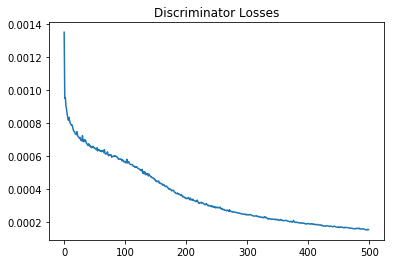

In [22]:
start = 0
end = 500
plt.figure()
# plt.subplot(121)
plt.plot(np.arange(start,end),d_losses[start:end])
plt.title('Discriminator Losses')
# plt.subplot(122)
# plt.plot(np.arange(start,end),g_losses[start:end])
# plt.title('Generator Losses')

In [90]:
weightspath = './weights/2018-06-04_18-34-00/G_epoch_126.weights'
checkpoint = torch.load(weightspath)
G.load_state_dict(checkpoint)

In [37]:
testiter = iter(testloader)

(-0.5, 255.5, 255.5, -0.5)

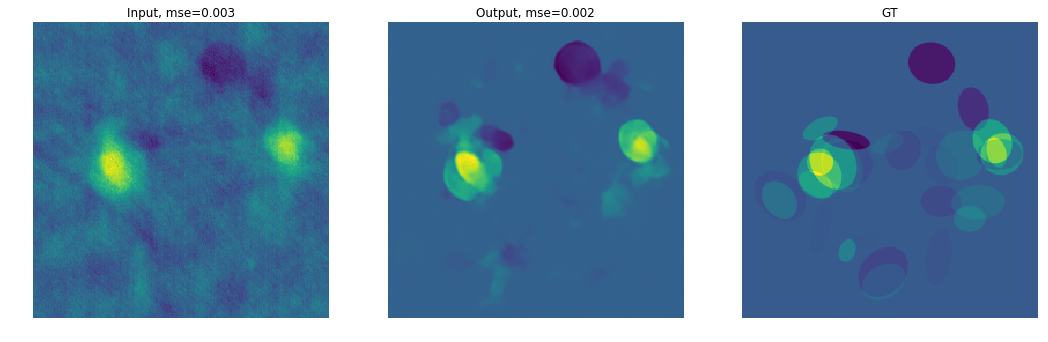

In [49]:
y,x = testiter.next()
G.eval()
GPU = True
if GPU:
    xhat = G(Variable(y.cuda(),volatile=True))
    xhat = xhat.cpu().data
else:
    xhat = G(Variable(y)).data
plt.figure(figsize=(18,6))
plt.subplot(131)
mse =torch.mean((y[0,0,:,:]-x[0,0,:,:])**2)
plt.imshow(y[0,0,...].numpy())
plt.title('Input, mse=%.3f'%(mse))
plt.axis('off')

mse =torch.mean((xhat[0,0,:,:]-x[0,0,:,:])**2)
plt.subplot(132)
plt.imshow(xhat[0,0,...].numpy())
plt.title('Output, mse=%.3f'%(mse))
plt.axis('off')

plt.subplot(133)
plt.imshow(x[0,0,...].numpy())
plt.title('GT')
plt.axis('off')

In [77]:
def test_mse(G, testloader):
    # Calculate Test MSE
    test_mses = np.zeros(len(testloader))
    for i,data in enumerate(testloader):
        y,x = data 
        GPU = True
        if GPU:
            xhat = G(Variable(y.cuda(),volatile=True))
            xhat = xhat.cpu().data
        else:
            xhat = G(Variable(y,volatile=True)).data

        test_mses[i] = torch.mean((xhat[:,0,:,:]-x[:,0,:,:])**2)
    return test_mses.mean()

In [79]:
mse = test_mse(G,testloader)
print('Test MSE = %f'%(mse))

Test MSE = 0.001482


In [86]:
len(range(0,500,25)), len(trained_nets)

(20, 21)

In [87]:
mses = np.zeros(21)
basepath = './weights/2018-06-04_18-34-00/G_epoch_'

for i,epoch in enumerate(range(0,500,25)):
    weightspath = basepath + str(epoch+1) + '.weights'
    checkpoint = torch.load(weightspath)
    G.load_state_dict(checkpoint)
    G = G.cuda()
    mses[i] = test_mse(G,testloader)
weightspath = basepath + str(500) + '.weights'
checkpoint = torch.load(weightspath)
G.load_state_dict(checkpoint)
G = G.cuda()
mses[-1] = test_mse(G,testloader)

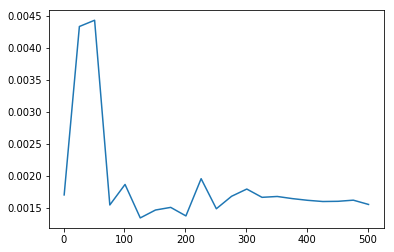

In [89]:
plt.plot(np.arange(1,502,25),mses)

In [96]:
print(mses[-1], mses.min())

0.0015492109404315864 0.001338506935090303


In [97]:
test_mses = np.zeros(len(testloader))

for i,data in enumerate(testloader):
    y,x = data 

    test_mses[i] = torch.mean((y[:,0,:,:]-x[:,0,:,:])**2)
print(test_mses.mean())

0.002872662238750937


In [ ]:
G = G.cpu()
torch.save(G.state_dict(),'Gmse_100.weights')
D = D.cpu()
torch.save(D.state_dict(),'Dmse_100.weights')

if GPU:
    G = G.cuda()
    D = D.cuda()
